In [1]:
import tensorflow as tf

import os
import pathlib
import time
import datetime
import numpy as np
import io_utils

from matplotlib import pyplot as plt
from IPython import display

print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.8.0


In [2]:
if tf.test.gpu_device_name(): 
    print("Default GPU: {}".format(tf.test.gpu_device_name()))
else:
    print("Not using a GPU - it will take long!!")

Default GPU: /device:GPU:0


In [3]:
from configuration import *
print("DATASET_SIZE", DATASET_SIZE)
print("TRAIN_SIZE", TRAIN_SIZE)
print("TEST_SIZE", TEST_SIZE)

np.random.seed(SEED)
tf.random.set_seed(SEED)

DATASET_SIZE 408
TRAIN_SIZE 347
TEST_SIZE 61


In [4]:
# Some images have transparent pixels with colors other than black
# This function turns all transparent pixels to black
# TFJS does this by default, but TF does not
# The TFJS imported model was having bad inference because of this
def blacken_transparent_pixels(image):
    mask = tf.math.equal(image[:, :, 3], 0)
    repeated_mask = tf.repeat(mask, INPUT_CHANNELS)
    condition = tf.reshape(repeated_mask, image.shape)
    
    image = tf.where(
        condition,
        image * 0.,
        image * 1.)
    return image


# replaces the alpha channel with a white color (only 100% transparent pixels)
def replace_alpha_with_white(image):
    mask = tf.math.equal(image[:, :, 3], 0)
    repeated_mask = tf.repeat(mask, INPUT_CHANNELS)
    condition = tf.reshape(repeated_mask, image.shape)
    
    image = tf.where(
        condition,
        255.,
        image)

    # drops the A in RGBA
    image = image[:, :, :3]
    return image


# rescales images in the interval [-1, 1]
def normalize(image):
    return (image / 127.5) - 1


# loads an image from the file system and transforms it for the network:
# (a) casts to float, (b) ensures transparent pixels are black-transparent, and (c)
# puts the values in the range of [-1, 1]
def load_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=INPUT_CHANNELS)
    image = tf.reshape(image, (IMG_SIZE, IMG_SIZE, INPUT_CHANNELS))
    image = tf.cast(image, tf.float32)
    image = blacken_transparent_pixels(image)
    if OUTPUT_CHANNELS == 3:
        image = replace_alpha_with_white(image)
    image = normalize(image)
    return image


In [5]:
def create_image_loader(sprite_side_source, sprite_side_target, dataset_sizes, train_or_test_folder):
    """
    Returns a function which takes an integer in the range of [0, DATASET_SIZE-1] and loads some image file
    from the corresponding dataset (using image_number and DATASET_SIZES to decide).
    """
    def load_images(image_number):
        image_number = tf.cast(image_number, "int32")

        # finds the dataset index and image number considering the param is an int in an imaginary concatenated array of all datasets
        dataset_index = tf.constant(0, dtype="int32")
        condition = lambda image_number, dataset_index: image_number >= tf.gather(dataset_sizes, dataset_index)
        body = lambda image_number, dataset_index: [image_number - tf.gather(dataset_sizes, dataset_index), dataset_index + 1]
        image_number, dataset_index = tf.while_loop(condition, body, [image_number, dataset_index])
        
        # gets the string pointing to the correct images
        dataset = tf.gather(DATA_FOLDERS, dataset_index)
        image_number = tf.strings.as_string(image_number)
        input_image = load_image(tf.strings.join([dataset, os.sep, train_or_test_folder, os.sep, DIRECTION_FOLDERS[sprite_side_source], os.sep, image_number, ".png"]))
        real_image = load_image(tf.strings.join([dataset, os.sep, train_or_test_folder, os.sep, DIRECTION_FOLDERS[sprite_side_target], os.sep, image_number, ".png"]))        
        
        return input_image, real_image
    return load_images


In [6]:
train_dataset = tf.data.Dataset.range(TRAIN_SIZE).shuffle(TRAIN_SIZE)
test_dataset = tf.data.Dataset.range(TEST_SIZE).shuffle(TEST_SIZE)

f2r_train_dataset = train_dataset.map(create_image_loader(2, 3, TRAIN_SIZES, "train"), num_parallel_calls=tf.data.AUTOTUNE)
f2r_train_dataset = f2r_train_dataset.batch(BATCH_SIZE)
f2r_test_dataset = test_dataset.map(create_image_loader(2, 3, TEST_SIZES, "test"))
f2r_test_dataset = f2r_test_dataset.batch(BATCH_SIZE)

f2b_train_dataset = train_dataset.map(create_image_loader(2, 0, TRAIN_SIZES, "train"), num_parallel_calls=tf.data.AUTOTUNE)
f2b_train_dataset = f2b_train_dataset.batch(BATCH_SIZE)
f2b_test_dataset = test_dataset.map(create_image_loader(2, 0, TEST_SIZES, "test"))
f2b_test_dataset = f2b_test_dataset.batch(BATCH_SIZE)

f2l_train_dataset = train_dataset.map(create_image_loader(2, 1, TRAIN_SIZES, "train"), num_parallel_calls=tf.data.AUTOTUNE)
f2l_train_dataset = f2l_train_dataset.batch(BATCH_SIZE)
f2l_test_dataset = test_dataset.map(create_image_loader(2, 1, TEST_SIZES, "test"))
f2l_test_dataset = f2l_test_dataset.batch(BATCH_SIZE)

Last 1000 steps took: 123.98s
Estimated time to finish: 0.00min



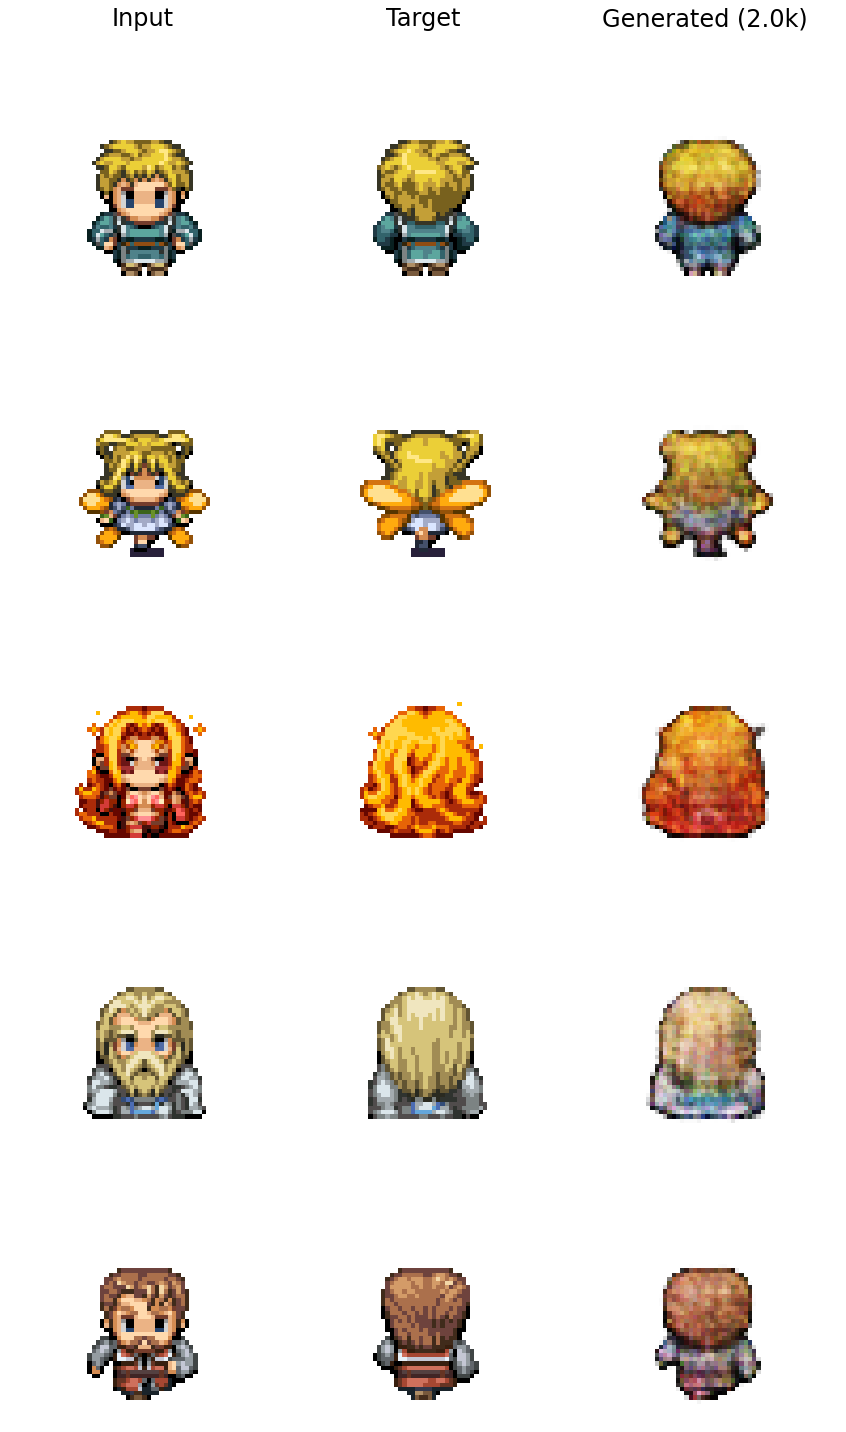

Step: 2.0k


In [7]:
Pix2PixModel = None
from pix2pix_model import Pix2PixModel, Pix2PixWassersteinModel, Pix2PixFFTModel


# f2r = Pix2PixFFTModel(f2r_train_dataset, f2r_test_dataset, "front2right", "pix2pix-rpgmakerxp-fftsquare1000", LAMBDA_FFT=1000)
model = Pix2PixModel(f2b_train_dataset, f2b_test_dataset, "front2back", "pix2pix-playground")
# f2r = Pix2PixWassersteinModel(f2r_train_dataset, f2r_test_dataset, "front2right", "pix2pix-wgan")
STEPS = 2000
print("Starting training...")
model.fit(STEPS, 1000, callbacks=[])#, callbacks=["fid", "show_patches"])


In [8]:
# f2r.load_generator()
# model.generate_images_from_dataset()

In [9]:
# model.save_generator()
# model.save_discriminator()

In [10]:
# print("Showing discriminator output from TRAIn set...")
# model.generate_discriminated_images("train")
# print("Showing discriminator output from TEST set...")
# model.generate_discriminated_images("test")